In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('yacht')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 2000, hidden_layers = [30, 30], learning_rate = 0.001, exp_decay = .998)

initial loss:  1.1716411113739014
final loss:  -7.3053107261657715
initial loss:  1.224480390548706
final loss:  -7.6661696434021
initial loss:  1.1239733695983887
final loss:  -7.714700222015381
initial loss:  1.0935015678405762
final loss:  -7.435107231140137
initial loss:  1.2970569133758545
final loss:  -7.245080947875977


Deep ensemble test MAPE:  0.30091956
Deep ensemble test RMSE:  1.468625
Deep ensemble test NLLK:  -0.53091145
Deep ensemble test CRPS:  tensor(0.5183)


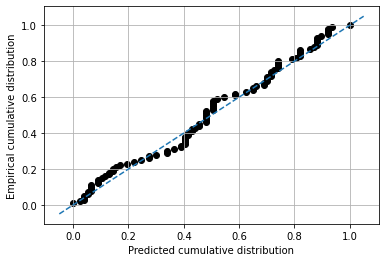

Deep ensemble test calibration error when step size is 0.001:  1.1492109124641603
Deep ensemble test calibration error when step size is 0.01:  0.11950328891887343
Deep ensemble test calibration error when step size is 0.1:  0.013366503626243894


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.94it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.73it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.684
  RMSE          1.469
  MDAE          0.195
  MARPD         21.435
  R2            0.993
  Correlation   0.997
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.041
  Mean-absolute Calibration Error       0.035
  Miscalibration Area                   0.036
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.172
     Group Size: 0.56 -- Calibration Error: 0.068
     Group Size: 1.00 -- Calibration Error: 0.035
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.195
     Group Size: 0.56 -- Calibration Error: 0.089
     Group Size: 1.00 -- Calibration Error: 0.041
===============

Lims is None. Setting lims now:
min_max_true: (0.08, 62.42)
min_max_pred: (-0.24829006, 56.21802)
lims: (-0.24829006, 62.42)
lims_ext: (-6.515118980407715, 68.68682708740235)


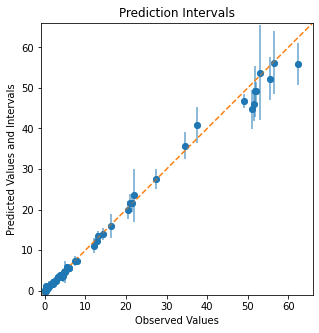

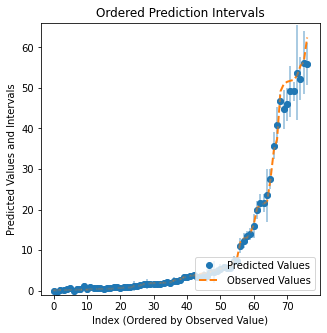

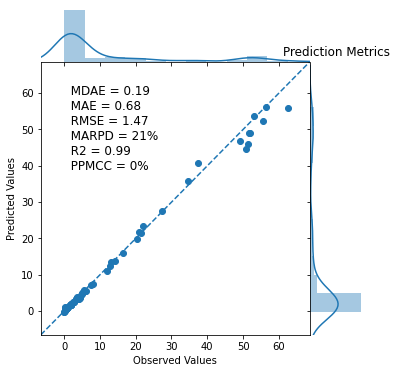

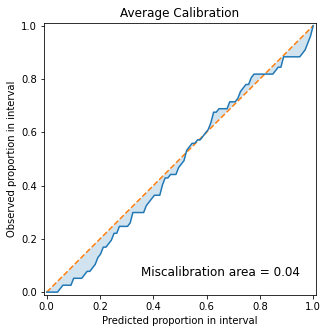

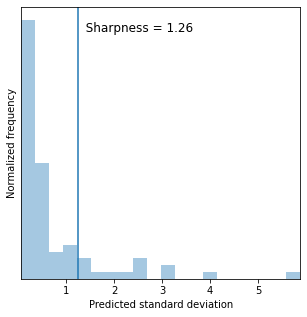

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [8]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 1000, n_features = 100, learning_rate = 0.001)

final loss:  -5.177908420562744


Concrete dropout test MAPE:  0.58859444
Concrete dropout test RMSE:  2.798316
Concrete dropout test NLLK:  2.0284762
Concrete dropout test CRPS:  tensor(1.2853)


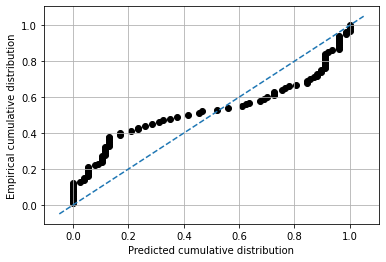

Concrete dropout test calibration error when step size is 0.001:  16.42138564682071
Concrete dropout test calibration error when step size is 0.01:  1.6624245235284194
Concrete dropout test calibration error when step size is 0.1:  0.17659807724742785


In [9]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy()) * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [10]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.68it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.52it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.478
  RMSE          2.798
  MDAE          0.470
  MARPD         36.690
  R2            0.974
  Correlation   0.988
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.243
  Mean-absolute Calibration Error       0.218
  Miscalibration Area                   0.221
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.343
     Group Size: 0.56 -- Calibration Error: 0.260
     Group Size: 1.00 -- Calibration Error: 0.218
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.373
     Group Size: 0.56 -- Calibration Error: 0.288
     Group Size: 1.00 -- Calibration Error: 0.243
===============

In [11]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.66it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.62it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.478
  RMSE          2.798
  MDAE          0.470
  MARPD         36.690
  R2            0.974
  Correlation   0.988
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.243
  Mean-absolute Calibration Error       0.218
  Miscalibration Area                   0.221
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.330
     Group Size: 0.56 -- Calibration Error: 0.261
     Group Size: 1.00 -- Calibration Error: 0.218
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.361
     Group Size: 0.56 -- Calibration Error: 0.287
     Group Size: 1.00 -- Calibration Error: 0.243
===============

In [33]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 2000, hidden_layers = [30, 30], learning_rate = 0.003, exp_decay = .999)

initial loss:  1.129982352256775
final loss:  -5.365441799163818


Subnetwork test MAPE:  0.22492273
Subnetwork test RMSE:  1.7615814
Subnetwork test NLLK:  0.097348765
Subnetwork test CRPS:  tensor(0.6075)


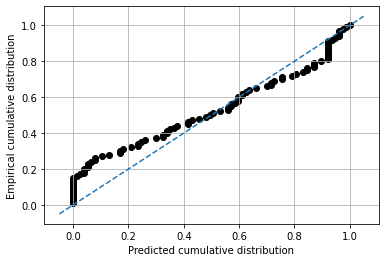

Subnetwork test calibration error when step size is 0.001:  7.4052787147917005
Subnetwork test calibration error when step size is 0.01:  0.7433251813121942
Subnetwork test calibration error when step size is 0.1:  0.06963231573621184


In [34]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [36]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.56it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.20it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.20it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.833
  RMSE          1.762
  MDAE          0.262
  MARPD         23.273
  R2            0.990
  Correlation   0.997
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.158
  Mean-absolute Calibration Error       0.134
  Miscalibration Area                   0.135
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.266
     Group Size: 0.56 -- Calibration Error: 0.172
     Group Size: 1.00 -- Calibration Error: 0.134
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.270
     Group Size: 0.56 -- Calibration Error: 0.199
     Group Size: 1.00 -- Calibration Error: 0.158
===============

Lims is None. Setting lims now:
min_max_true: (0.08, 62.42)
min_max_pred: (-0.091465, 55.50071)
lims: (-0.091465, 62.42)
lims_ext: (-6.342611312866211, 68.67114448547363)


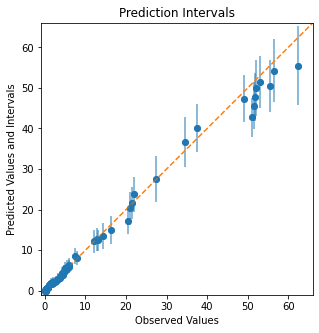

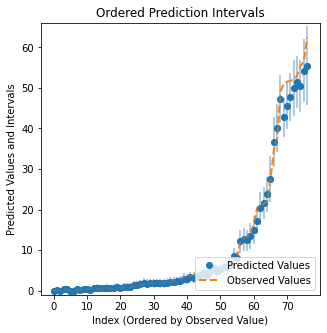

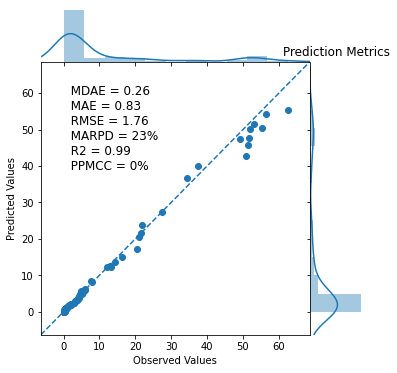

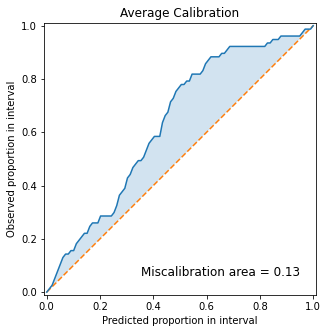

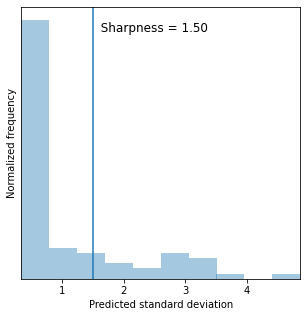

In [35]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))